In [37]:
#숫자 처리/그림 그리기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt #차트그리기

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.init


import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' 

데이터 가지고 오는 것은 앞에서 가지고 옴


In [19]:
mnist_train=dsets.MNIST(root='../data02/mnist_data', #없으면 다운받고 있으면 꺼내는 root
                           train=True,
                           download=True,
                           transform=transforms.Compose([transforms.ToTensor()]))
mnist_test=dsets.MNIST(root='../data02/mnist_data',
                           train=False,
                           download=True,
                           transform=transforms.Compose([transforms.ToTensor()]))

확인하는 건 생략하셨데. 크기랑 기타등등

In [33]:
print(mnist_train)
print(mnist_test)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data02/mnist_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data02/mnist_data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [34]:
def plot(x,y):
  plt.figure(figsize=(8,10))
  for i in range(len(x)):
    plt.subplot(5,5, i+1) 
    img=(np.array(x[i], dtype='float')).reshape(28,28) 
    plt.title(y[i].item()) 
    plt.imshow(img, cmap='gray')
    plt.axis('off') 
  plt.show()

C:\Users\it\AppData\Local\Temp\ipykernel_7464\256436322.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  img=(np.array(x[i], dtype='float')).reshape(28,28)


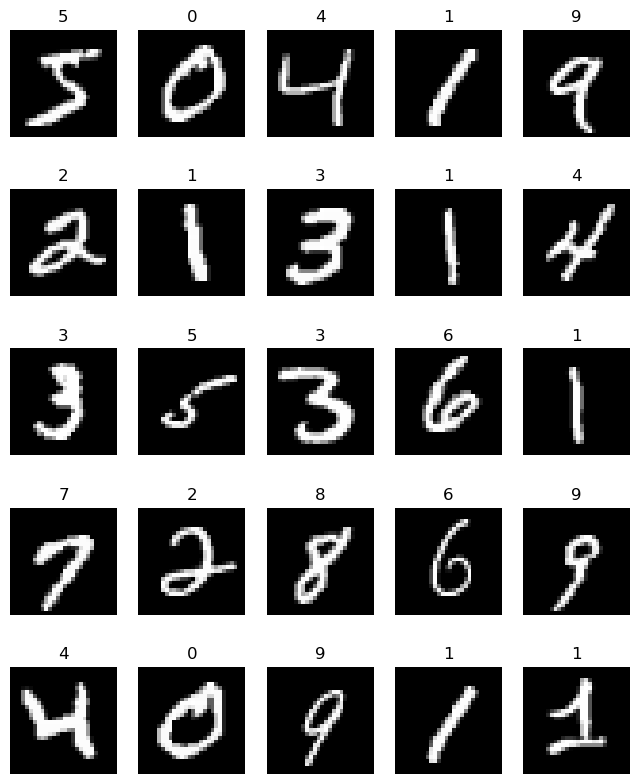

In [38]:
plot(mnist_train.data[:25], mnist_train.targets[:25])

In [20]:
device='cuda' if torch.cuda.is_available() else 'cpu' #그렇지 않으면 cpu
print(device)

cpu


cuda는 GPU를 사용할 수 있는 상태. CPU는 하나의 처리 끝나고 다음거 가는데 쿠다는 병렬로
게임이나 인공지능용으로 사용하는 경우 cuda 장비
- GPU 15만개 확보가 대단하다고 뉴스나올 정도로 전력이 높아야지 사용 가능한 
- 하여간 쿠다 사용 가능하면 가능하다고 나와. 코렙에서 사용할거야

쿠다 설정
쿠다의 랜덤 시드도 777로 쓰겠다.

In [21]:
torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)
  

In [22]:
learing_rate=0.001
epochs=30
batch_size=100

저장된 데이터를 로드를 통해서 배치사이즈만큼 suffle 해서 load 함

In [23]:
train_loader = DataLoader(dataset=mnist_train, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          drop_last=True)

test_loader = DataLoader(dataset=mnist_test, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          drop_last=True)

In [24]:
for X, Y in train_loader:
  print(X.size(), Y.size())
  

torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([1

CNN 구축

In [ ]:
class CNN(nn.Module):
  def __init__(self): #모델정의
    super().__init__()

#2단을 쌓을거야 28*28 한번 폴링하면 14 -> 7 7 이후로 3.5는 애매해서 못 쌓
    self.layer1 = nn.Sequential(
      nn.Conv2d(1, 32, kernel_size=3, padding=1), #컨볼루션 32개 특징 탐지
      #cifer10을 사용하면 채널이 3개니까 1대신 3으로 넣음
      nn.ReLU(), #음수 버리기
      nn.MaxPool2d(kernel_size=2, stride=2) #요약+다운샘플링, stride=2 겹치지 않게 이동
    )
    #image shape(100, 1, 28, 28) 이미지 100, 채널 1, 크기 28*28
    # conv1 -> (1, 32, 28, 28) 채널값, 출력값, size
    # pool -> (1, 32, 14, 14) 값이 요렇게 된다.

    self.layer2 = nn.Sequential(
      nn.Conv2d(32, 64, kernel_size=3, padding=1), # 2의 지수승이 출력 64
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )
    #image shape(?, 32, 14, 14) 이미지수? 채널32, 크기 14*14
    # conv1 -> (32, 64, 14, 14) 채널값, 출력값, size
    # pool -> (32, 64, 7, 7) 값이 요렇게 된다.

    #완전결합층 7*7*64 해서 완전 연결 1차원 결합층 -> 10가지 값 중 1개가 되게 출력 10
    # 복잡하면 단 여러개 쌓아서 딥러닝 하면 됨????

    self.fc=nn.Linear(7*7*64, 10, bias=True)
    # 완전결합층 한정으로 가중치 초기화
    nn.init.xavier_uniform_(self.fc.weight)

  #모델정의 완료

  #모델 실행부분

  def forward(self, x):
    out=self.layer1(x) #100개의 self 값이 들어옴
    out=self.layer2(out)
    out=out.view(out.size(0),-1)  #이미지 1차원으로 펼침

    out=self.fc(out)
    return out
  


In [28]:
model = CNN().to(device) #device 세팅:쿠다면 쿠다, 아니면 cpu 사용하게 세팅
crit=nn.CrossEntropyLoss().to(device) #손실함수 계산
optimizer=optim.Adam(model.parameters(), lr=learing_rate) 
#초기 러닝메이트이고, Adam이 적응 러닝메이트로 조절함.

total 배치 구하기

In [29]:
total_batch=len(train_loader) #훈련데이터 배치 수 구하기 6만개 100개 -> 600개

훈련시키기

In [30]:
for epoch in range(epochs):
  avg_cost=0

  #배치를 돌려야하니 for
  for X, Y in train_loader:
    X=X.to(device)
    Y=Y.to(device)

    optimizer.zero_grad()
    y_hat=model(X) #결과
    cost=crit(y_hat, Y)
    cost.backward()
    optimizer.step()

    avg_cost+=cost
  avg_cost=avg_cost/total_batch #햇갈릴 것 같으면 이렇게 쓸라심. 현재 코스트 평균코스트
  print(f'epoch:{epoch}, cost:{avg_cost}')



epoch:0, cost:0.2191239446401596
epoch:1, cost:0.06311912834644318
epoch:2, cost:0.04724063724279404
epoch:3, cost:0.03735823556780815
epoch:4, cost:0.03127768263220787
epoch:5, cost:0.026514185592532158
epoch:6, cost:0.02250692807137966
epoch:7, cost:0.018488530069589615
epoch:8, cost:0.015866858884692192
epoch:9, cost:0.013112349435687065
epoch:10, cost:0.01144155953079462
epoch:11, cost:0.009146788157522678
epoch:12, cost:0.009166247211396694
epoch:13, cost:0.007253013551235199
epoch:14, cost:0.005880169104784727
epoch:15, cost:0.005619622301310301
epoch:16, cost:0.0055437758564949036
epoch:17, cost:0.006387476343661547
epoch:18, cost:0.0034280049148947
epoch:19, cost:0.003209827933460474
epoch:20, cost:0.0032228422351181507
epoch:21, cost:0.0042749568819999695
epoch:22, cost:0.0038123922422528267
epoch:23, cost:0.0020520044490695
epoch:24, cost:0.002092940267175436
epoch:25, cost:0.003840735414996743
epoch:26, cost:0.0015710205771028996
epoch:27, cost:0.0006343728164210916
epoch:28

얼리스탑을 안하고 오버피팅이 되어있어도 잘나옴. 98%까지 나옴. 

In [32]:
with torch.no_grad():
  avg_accuracy = 0

  for x_test, y_test in test_loader:
    x_test=mnist_test.data.view(len(mnist_test), 1, 28, 28).float().to(device)
  #view 해서 데이터 모양을 바꿈.
    y_test=mnist_test.targets.to(device)

    pred=model(x_test)
    correct_pred=torch.argmax(pred, -1) == y_test 
    #한 데이터가 10가지 값으로 나와 가장 큰 값, y-test와 비교하여 맞는 것은 true
    accuracy=correct_pred.float().mean() #평균값 
    # accuracy=correct_pred.sum()/len(pred) sum하고 테스트 갯수로 나눠도 됨
  print(f'Accuracy:{accuracy}') #정확도 몇퍼센트인지

Accuracy:0.9878000020980835


훈련이 더 되서 오버피팅 되어있을 수 있어. 시간은 좀 걸렸어. 하지만 결과가 좋다!!